# Data mining of social networks
## Girvan Newman Algorithm

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import copy

 The number of connected components are  1
 The number of connected components are  1
 The number of connected components are  1


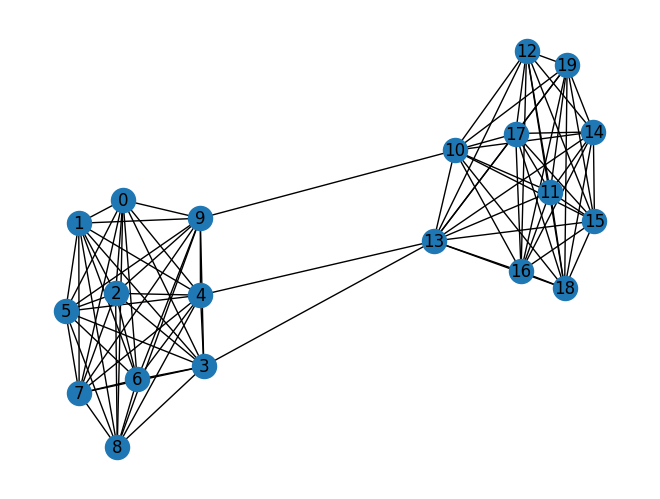

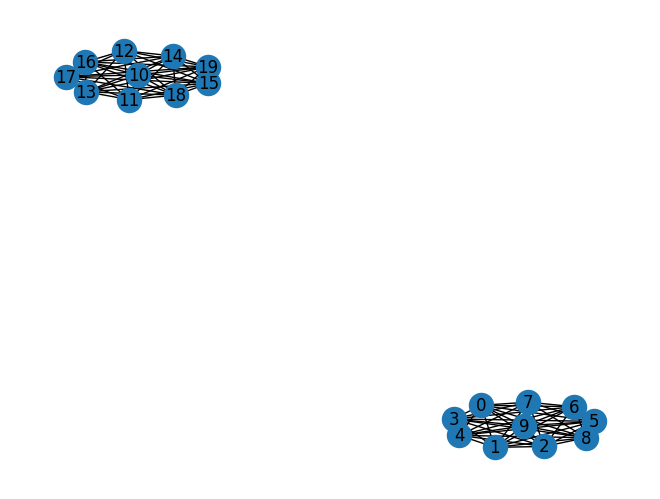

In [3]:
def edge_to_remove(g):
    centrality = nx.edge_betweenness_centrality(g, weight="weight")
    return max(centrality, key=centrality.get)
  
def girvan_newman_alg(g):
    a = nx.connected_components(g)
    lena = len(list(a))
    while (lena == 1):
        # We need (a,b) instead of ((a,b))
        u, v = edge_to_remove(g)
        g.remove_edge(u, v) 

        a = nx.connected_components(g)
        lena=len(list(a))
    
    return a
  
# Driver Code
g = nx.barbell_graph(10, 0)
g.add_edge(3, 13)
g.add_edge(4, 13)
plt.figure(1)
nx.draw(g, with_labels = True)

# Call the function
a = girvan_newman_alg(g)
plt.figure(2)
nx.draw(g, with_labels = True)

## Normalised Min Cut Algorithm

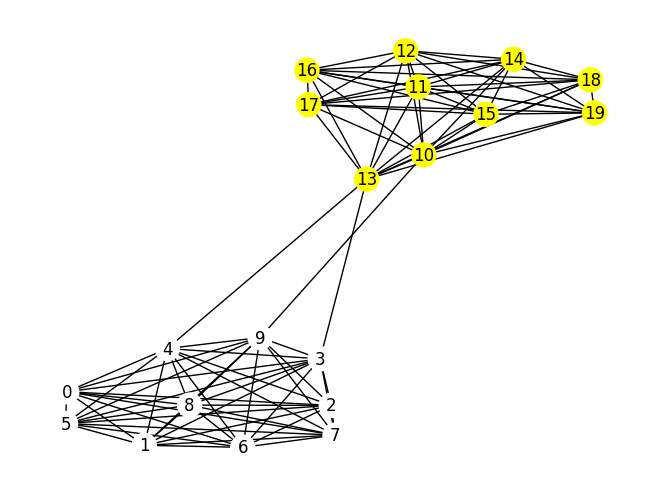

In [4]:
def normalized_min_cut(graph):
    m_adjacency = np.array(nx.to_numpy_matrix(graph))

    D = np.diag(np.sum(m_adjacency, 0))
    D_half_inv = np.diag(1.0 / np.sqrt(np.sum(m_adjacency, 0)))
    M = np.dot(D_half_inv, np.dot((D - m_adjacency), D_half_inv))

    (w, v) = np.linalg.eig(M)
    #find index of second smallest eigenvalue
    index = np.argsort(w)[1]

    v_partition = v[:, index]
    v_partition = np.sign(v_partition)   
    return v_partition

g = nx.barbell_graph(10, 0)
g.add_edge(3, 13)
g.add_edge(4, 13)

a = normalized_min_cut(g)
colors = np.zeros((len(a), 3)) + 1.0
colors[:, 2] = np.where(a >= 0, 1.0, 0)

plt.figure(1)
nx.draw(g, with_labels = True, node_color = colors)
 



## SimRank Algorithm

0.2885050165883117


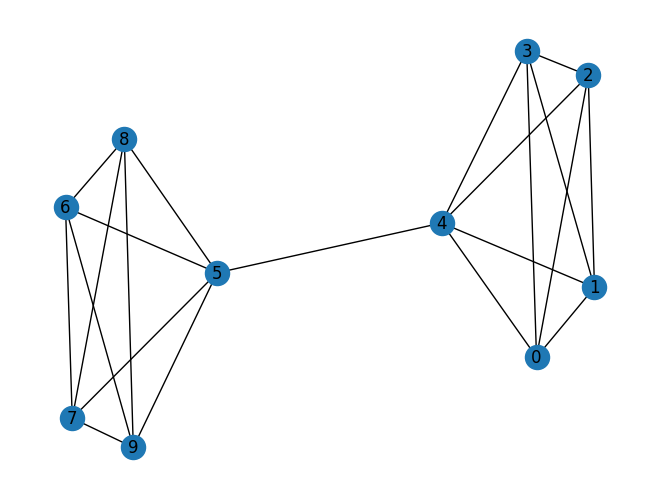

In [5]:
def simrank(G, c=0.9, max_iter=100, remove_neighbors=False, remove_self=False):
  sim_old = defaultdict(list)
  sim = defaultdict(list)
  for n in G.nodes():
    sim[n] = defaultdict(int)
    sim[n][n] = 1
    sim_old[n] = defaultdict(int)
    sim_old[n][n] = 0

  # calculate simrank
  for iter_ctr in range(max_iter):
    if _is_converge(sim, sim_old):
      break
    sim_old = copy.deepcopy(sim)
    for i, u in enumerate(G.nodes()):
      for v in G.nodes():
        if u == v:
          continue
        s_uv = 0.0
        for n_u in G.neighbors(u):
          for n_v in G.neighbors(v):
            s_uv += sim_old[n_u][n_v]
        sim[u][v] = (c * s_uv / (len(list(G.neighbors(u))) * len(list(G.neighbors(v))))) \
            if len(list(G.neighbors(u))) * len(list(G.neighbors(v))) > 0 else 0
  if remove_self:
    for m in G.nodes():
      G[m][m] = 0

  if remove_neighbors:
    for m in G.nodes():
      for n in G.neighbors(m):
        sim[m][n] = 0

  return sim

def _is_converge(s1, s2, eps=1e-4):
  for i in s1.keys():
    for j in s1[i].keys():
      if abs(s1[i][j] - s2[i][j]) >= eps:
        return False
  return True



g = nx.barbell_graph(5, 0)
nx.draw(g, with_labels = True)

s = simrank(g)
print(s[4][5])

## Triangles Counting

3


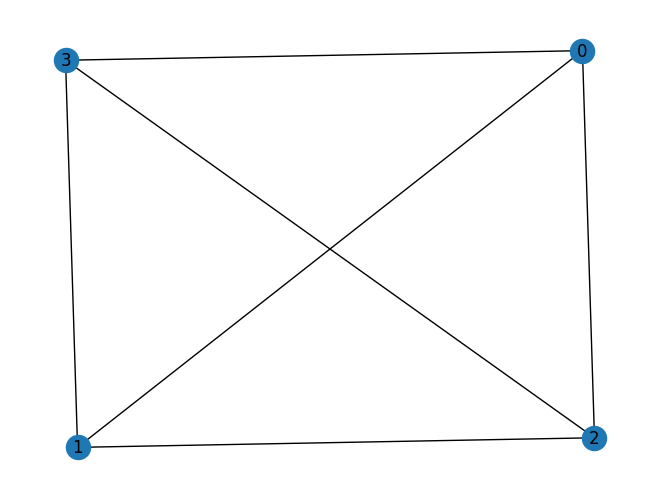

In [6]:
G = nx.complete_graph(4)
nx.draw(G, with_labels = True)

t = nx.triangles(G, 0)
print(t)

## Reachability

EdgeView([(0, 7), (0, 4), (0, 2), (0, 3), (0, 8), (0, 9), (0, 1), (0, 5), (0, 6), (7, 2), (7, 3), (7, 4), (7, 9), (7, 1), (7, 8), (7, 6), (7, 5), (1, 3), (1, 5), (1, 9), (1, 4), (1, 8), (1, 6), (1, 2), (3, 4), (3, 5), (3, 9), (3, 8), (3, 2), (3, 6), (4, 8), (4, 2), (4, 5), (4, 6), (4, 9), (2, 9), (2, 6), (2, 8), (2, 5), (5, 8), (5, 6), (5, 9), (8, 6), (8, 9), (6, 9)])

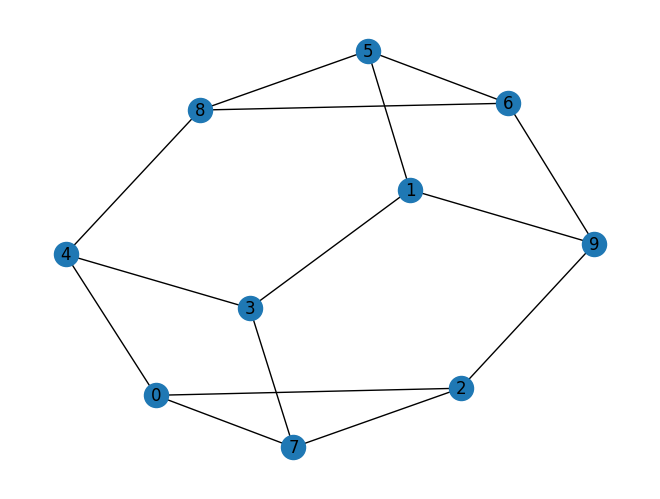

In [7]:
DG = nx.random_regular_graph(3, 10)

nx.draw(DG, with_labels = True)
TC = nx.transitive_closure(DG, reflexive=False)
TC.edges()

# reachabble if the re is an edge between them